In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sber_data = pd.read_csv('../data/sber_data.csv')

In [3]:
sber_data['price_doc'].max()

111111112

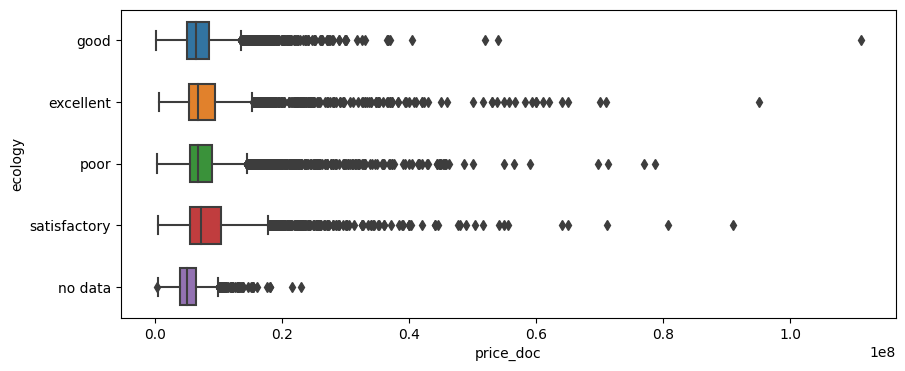

In [4]:
fig = plt.figure(figsize=(10, 4))
boxplot = sns.boxplot(
    data=sber_data,
    x='price_doc',
    y='ecology',
    orient='h',
    width=0.6
)

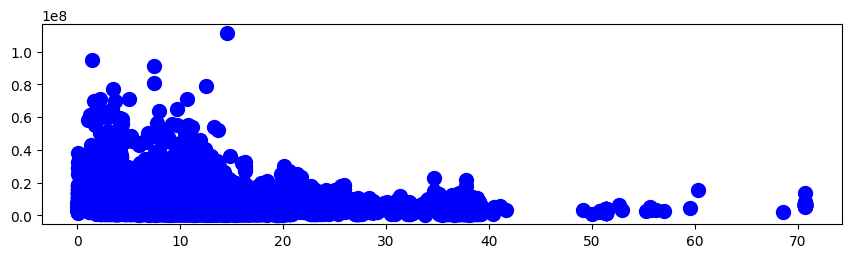

In [5]:
axes = plt.figure(figsize=(8, 2)).add_axes([0, 0, 1, 1])
axes.scatter(
    y=sber_data['price_doc'], 
    x=sber_data['kremlin_km'], 
    s=100,
    marker='o',
    c = 'blue'
);

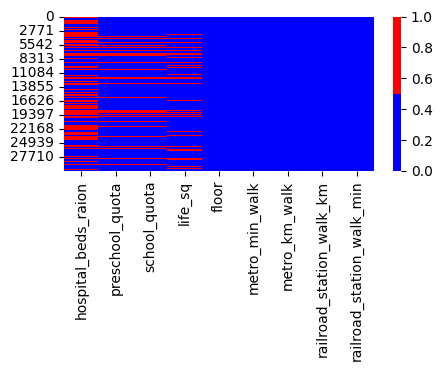

In [6]:
cols_null_percent = sber_data.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
colors = ['blue', 'red'] 
fig = plt.figure(figsize=(5, 2))
cols = cols_with_null.index
ax = sns.heatmap(
    sber_data[cols].isnull(),
    cmap=sns.color_palette(colors),
)

In [8]:
drop_data = sber_data.copy()
thresh = drop_data.shape[0]*0.7
drop_data = drop_data.dropna(thresh=thresh, axis=1)
drop_data = drop_data.dropna(how='any', axis=0)

In [9]:
fill_data = sber_data.copy()
values = {
    'life_sq': fill_data['full_sq'],
    'metro_min_walk': fill_data['metro_min_walk'].median(),
    'metro_km_walk': fill_data['metro_km_walk'].median(),
    'railroad_station_walk_km': fill_data['railroad_station_walk_km'].median(),
    'railroad_station_walk_min': fill_data['railroad_station_walk_min'].median(),
    'hospital_beds_raion': fill_data['hospital_beds_raion'].mode()[0],
    'preschool_quota': fill_data['preschool_quota'].mode()[0],
    'school_quota': fill_data['school_quota'].mode()[0],
    'floor': fill_data['floor'].mode()[0]
}
fill_data = fill_data.fillna(values)

In [10]:
indicator_data = sber_data.copy()
for col in cols_with_null.index:
    indicator_data[col + '_was_null'] = indicator_data[col].isnull()
    values = {
    'life_sq': indicator_data['full_sq'],
    'metro_min_walk': indicator_data['metro_min_walk'].median(),
    'metro_km_walk': indicator_data['metro_km_walk'].median(),
    'railroad_station_walk_km': indicator_data['railroad_station_walk_km'].median(),
    'railroad_station_walk_min': indicator_data['railroad_station_walk_min'].median(),
    'hospital_beds_raion': indicator_data['hospital_beds_raion'].mode()[0],
    'preschool_quota': indicator_data['preschool_quota'].mode()[0],
    'school_quota': indicator_data['school_quota'].mode()[0],
    'floor': indicator_data['floor'].mode()[0]
}
indicator_data = indicator_data.fillna(values)

In [11]:
combine_data = sber_data.copy()
n = combine_data.shape[0]
thresh = n*0.7
combine_data = combine_data.dropna(thresh=thresh, axis=1)

m = combine_data.shape[1]
combine_data = combine_data.dropna(thresh=m-2, axis=0)

values = {
    'life_sq': combine_data['full_sq'],
    'metro_min_walk': combine_data['metro_min_walk'].median(),
    'metro_km_walk': combine_data['metro_km_walk'].median(),
    'railroad_station_walk_km': combine_data['railroad_station_walk_km'].median(),
    'railroad_station_walk_min': combine_data['railroad_station_walk_min'].median(),
    'preschool_quota': combine_data['preschool_quota'].mode()[0],
    'school_quota': combine_data['school_quota'].mode()[0],
    'floor': combine_data['floor'].mode()[0]
}
combine_data = combine_data.fillna(values)

In [12]:
outliers = sber_data[sber_data['life_sq'] > sber_data['full_sq']]
cleaned = sber_data.drop(outliers.index, axis=0)

In [31]:
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

def outliers_iqr_mod(data, feature, left = 1.5, right = 1.5, log_scale = False):
    if log_scale:
        x = np.log(data[feature])
    else:
        x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

In [33]:
outliers, cleaned = outliers_iqr_mod(sber_data, 'price_doc', log_scale = True, left=3, right=3)
outliers.shape[0]


92

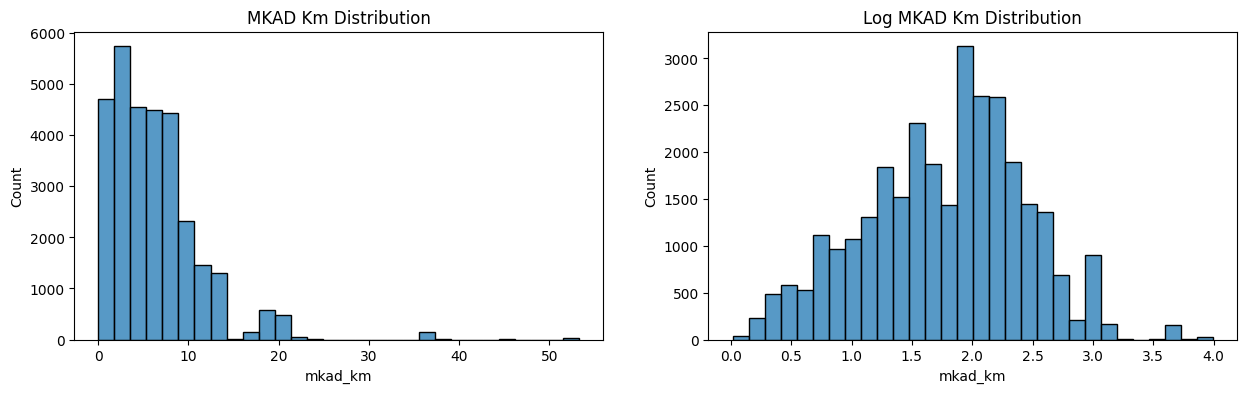

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

#гистограмма исходного признака
histplot = sns.histplot(sber_data['mkad_km'], bins=30, ax=axes[0])
histplot.set_title('MKAD Km Distribution');

#гистограмма в логарифмическом масштабе
log_mkad_km= np.log(sber_data['mkad_km'] + 1)
histplot = sns.histplot(log_mkad_km , bins=30, ax=axes[1])
histplot.set_title('Log MKAD Km Distribution');

In [26]:
def outliers_z_score(data, feature, log_scale=False):
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - 3 * sigma
    upper_bound = mu + 3 * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

def outliers_z_score_mod(data, feature, log_scale=False, left = 3, right = 3):
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - left * sigma
    upper_bound = mu + right * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

In [29]:
outliers, cleaned = outliers_z_score_mod(sber_data, 'price_doc', right=3.7, left = 3.7, log_scale=True)
outliers.shape[0]


52

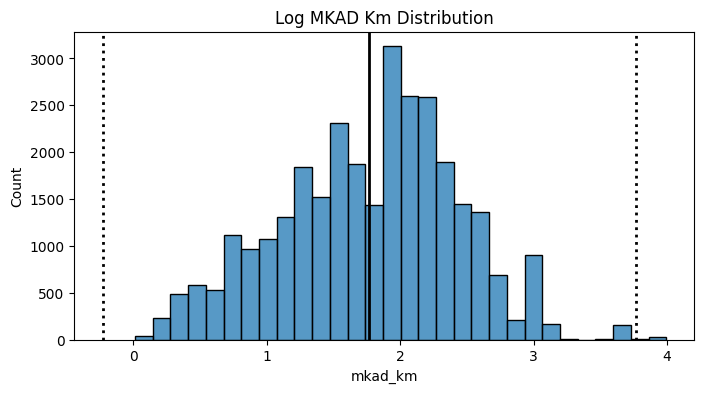

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
log_mkad_km = np.log(sber_data['mkad_km'] + 1)
histplot = sns.histplot(log_mkad_km, bins=30, ax=ax)
histplot.axvline(log_mkad_km.mean(), color='k', lw=2)
histplot.axvline(log_mkad_km.mean()+ 3 * log_mkad_km.std(), color='k', ls=':', lw=2)
histplot.axvline(log_mkad_km.mean()- 3 * log_mkad_km.std(), color='k', ls=':', lw=2)
histplot.set_title('Log MKAD Km Distribution');

In [35]:
dupl_columns = list(sber_data.columns)
dupl_columns.remove('id')

mask = sber_data.duplicated(subset=dupl_columns)
sber_duplicates = sber_data[mask]
sber_dedupped = sber_data.drop_duplicates(subset=dupl_columns)

In [36]:
low_information_cols = [] 

for col in sber_data.columns:
    top_freq = sber_data[col].value_counts(normalize=True).max()
    nunique_ratio = sber_data[col].nunique() / sber_data[col].count()
    if top_freq > 0.95:
        low_information_cols.append(col)
        print(f'{col}: {round(top_freq*100, 2)}% одинаковых значений')
    if nunique_ratio > 0.95:
        low_information_cols.append(col)
        print(f'{col}: {round(nunique_ratio*100, 2)}% уникальных значений')

id: 100.0% уникальных значений
oil_chemistry_raion: 99.03% одинаковых значений
railroad_terminal_raion: 96.27% одинаковых значений
nuclear_reactor_raion: 97.17% одинаковых значений
big_road1_1line: 97.44% одинаковых значений
mosque_count_1000: 98.08% одинаковых значений


In [37]:
information_sber_data = sber_data.drop(low_information_cols, axis=1)